To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/u54VK8m8tk"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
  <a href="https://ko-fi.com/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Kofi button.png" width="145"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://github.com/unslothai/unsloth#installation-instructions---conda).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save) (eg for Llama.cpp).

**[NEW] Llama-3 8b is trained on a crazy 15 trillion tokens! Llama-2 was 2 trillion.**

In [1]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install xformers trl peft accelerate bitsandbytes

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


* We support Llama, Mistral, CodeLlama, TinyLlama, Vicuna, Open Hermes etc
* And Yi, Qwen ([llamafied](https://huggingface.co/models?sort=trending&search=qwen+llama)), Deepseek, all Llama, Mistral derived archs.
* We support 16bit LoRA or 4bit QLoRA. Both 2x faster.
* `max_seq_length` can be set to anything, since we do automatic RoPE Scaling via [kaiokendev's](https://kaiokendev.github.io/til) method.
* [**NEW**] With [PR 26037](https://github.com/huggingface/transformers/pull/26037), we support downloading 4bit models **4x faster**! [Our repo](https://huggingface.co/unsloth) has Llama, Mistral 4bit models.

In [1]:
from unsloth import FastLanguageModel
from datasets import load_dataset, Dataset
from pydantic import BaseModel, ValidationError, Field
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
import torch
import os
from typing import Literal
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, accuracy_score
from collections import defaultdict
from trl import SFTTrainer
from transformers import TrainingArguments

max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = torch.bfloat16 # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/mistral-7b-instruct-v0.2-bnb-4bit",
    "unsloth/llama-2-7b-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit",
    "unsloth/gemma-7b-it-bnb-4bit", # Instruct version of Gemma 7b
    "unsloth/gemma-2b-bnb-4bit",
    "unsloth/gemma-2b-it-bnb-4bit", # Instruct version of Gemma 2b
    "unsloth/llama-3-8b-bnb-4bit",
    "unsloth/Phi-3-mini-4k-instruct" # [NEW] 15 Trillion token Llama-3
] # More models at https://huggingface.co/unsloth

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [4]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Phi-3-mini-4k-instruct",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
  )
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 100,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

config.json:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

==((====))==  Unsloth: Fast Mistral patching release 2024.5
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


model.safetensors:   0%|          | 0.00/2.26G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Unsloth 2024.5 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


<a name="Data"></a>
### Data Prep
We now use the Alpaca dataset from [yahma](https://huggingface.co/datasets/yahma/alpaca-cleaned), which is a filtered version of 52K of the original [Alpaca dataset](https://crfm.stanford.edu/2023/03/13/alpaca.html). You can replace this code section with your own data prep.

**[NOTE]** To train only on completions (ignoring the user's input) read TRL's docs [here](https://huggingface.co/docs/trl/sft_trainer#train-on-completions-only).

**[NOTE]** Remember to add the **EOS_TOKEN** to the tokenized output!! Otherwise you'll get infinite generations!

If you want to use the `ChatML` template for ShareGPT datasets, try our conversational [notebook](https://colab.research.google.com/drive/1Aau3lgPzeZKQ-98h69CCu1UJcvIBLmy2?usp=sharing).

For text completions like novel writing, try this [notebook](https://colab.research.google.com/drive/1ef-tab5bhkvWmBOObepl1WgJvfvSzn5Q?usp=sharing).

In [5]:
toefl_train = "/content/drive/MyDrive/thesis_NLI/TOEFL11/train_preprocessed.csv"

alpaca_prompt = '''
### Instruction:
You are a forensic linguistics expert that reads English texts written by non-native authors to classify the native language of the author as one of:"ARA": Arabic
"CHI": Chinese
"FRE": French
"GER": German
"HIN": Hindi
"ITA": Italian
"JPN": Japanese
"KOR": Korean
"SPA": Spanish
"TEL": Telugu
"TUR": Turkish
Use clues such as spelling errors, word choice, syntactic patterns, and grammatical errors to decide on the native language of the author.\n

DO NOT USE ANY OTHER CLASS.
IMPORTANT: Do not classify any input as "ENG" (English). English is an invalid choice.

Valid output formats:
Class: "ARA"
Class: "CHI"
Class: "FRE"
Class: "GER"

Classify the text below as one of ARA, CHI, FRE, GER, HIN, ITA, JPN, KOR, SPA, TEL, or TUR. Do not output any other class - do NOT choose "ENG" (English). What is the closest native language of the author of this English text from the given list?

### Input:
{}

### Response:
{}'''


EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    inputs       = examples["text"]
    outputs      = examples["language"]
    texts = []
    for input, output in zip(inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

from datasets import load_dataset
dataset = load_dataset("csv", data_files=toefl_train, split='train')
print(f'Number of samples: {len(dataset)}')
print(dataset[0])
texts = dataset['text']
labels = dataset ['language']
dataset = dataset.map(formatting_prompts_func, batched = True,)
print(dataset[:5])


Generating train split: 0 examples [00:00, ? examples/s]

Number of samples: 11000
{'text': "Some people might think that traveling in a group led by a tour guide is a good way. But, a group tour normally has its strict schedule and does not offer the tourists in group any chance to meet many people in new place. \nSo, I strongly disagree with the statement that the best way to travel is in a group led by a tour guide. \n\nFirst, a group tour has its own strict schedule and all the tour team members should follow it. And it means that I can not choose the place where I want go and the food which I want to eat. For example, when I went to Thailand for the first time, I chose a group tour because I was young and it was the first time to go abroad. I really wanted to go many attractive shops and spots in the street in Bangkok, but I couldn't go there because I was in a group tour and I had to follow the schedule which the tour company offered. And I had to wake up early in the morning and had to go back to hotel in early evening, even though I w

Map:   0%|          | 0/11000 [00:00<?, ? examples/s]

{'text': ['\n### Instruction:\nYou are a forensic linguistics expert that reads English texts written by non-native authors to classify the native language of the author as one of:"ARA": Arabic\n"CHI": Chinese\n"FRE": French\n"GER": German\n"HIN": Hindi\n"ITA": Italian\n"JPN": Japanese\n"KOR": Korean\n"SPA": Spanish\n"TEL": Telugu\n"TUR": Turkish\nUse clues such as spelling errors, word choice, syntactic patterns, and grammatical errors to decide on the native language of the author.\n\n\nDO NOT USE ANY OTHER CLASS.\nIMPORTANT: Do not classify any input as "ENG" (English). English is an invalid choice.\n\nValid output formats:\nClass: "ARA"\nClass: "CHI"\nClass: "FRE"\nClass: "GER"\n\nClassify the text below as one of ARA, CHI, FRE, GER, HIN, ITA, JPN, KOR, SPA, TEL, or TUR. Do not output any other class - do NOT choose "ENG" (English). What is the closest native language of the author of this English text from the given list?\n\n### Input:\nSome people might think that traveling in a 

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [6]:
from trl import SFTTrainer
from transformers import TrainingArguments

for ind, rs in zip(range(2,3), [100]):

  model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Phi-3-mini-4k-instruct",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
  )
  model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = rs,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
  )
  trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 4, # The batch size per GPU/TPU core/CPU for training. Zhang et al set this to 4
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        #max_steps = 0,
        num_train_epochs=3,
        learning_rate = 1e-4, # originally 2e-4
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = rs,
        output_dir = "outputs",
    ),
  )

  trainer_stats = trainer.train()
  model.save_pretrained(f"/content/drive/MyDrive/thesis_NLI/TOEFL11/finetuned_phi3_{ind}") # Local saving
  tokenizer.save_pretrained(f"/content/drive/MyDrive/thesis_NLI/TOEFL11/finetuned_phi3_{ind}")


==((====))==  Unsloth: Fast Mistral patching release 2024.5
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=2):   0%|          | 0/11000 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 11,000 | Num Epochs = 3
O^O/ \_/ \    Batch size per device = 4 | Gradient Accumulation steps = 4
\        /    Total batch size = 16 | Total steps = 2,061
 "-____-"     Number of trainable parameters = 29,884,416


Step,Training Loss
1,2.666500
2,2.516400
3,2.627600
4,2.575200
5,2.582400
6,2.276300
7,2.357500
8,2.244200
9,2.199100
10,2.198100


# Evaluate on TOEFL test set

In [10]:
def generate_text(prompt):
  """
  Generate text for LLM based on input prompt
  :param prompt: input prompt
  :param max_length:
  :type prompt: str
  :type max_length: int
  """
    # Tokenize the prompt
  inputs = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")
  outputs = model.generate(inputs,
                           max_new_tokens=10,
                           pad_token_id=tokenizer.eos_token_id,
                           #temperature=0.001
                           ) # set temperature here?
    # Decode the response
  response = tokenizer.decode(outputs[0], skip_special_tokens=True)

  return response

def clean_output(output, eos_token, output_only=False):
  """
  This function specifically cleans up the output given by Llama 2 chat,
  to remove the prompt, make sure it is in the correct format, and remove any empty lines.
  :param output: model generated output
  :param labels: all possible classes in TOEFL/ICLE
  :param eos_token: end-of-sequence token to split model output on
  :param output_only, default False: if True, extract only the newly generated output by model and remove the prompt. mostly used for debugging
  :type output: str
  :type labels: list
  :type eos_token: str
  """
  pure_output = output.split(eos_token)
  pure_output = pure_output[-1]
  pure_output = pure_output.strip()
  final_output = pure_output
  if output_only==False: # whether to extract only json-formatted string in the output or not
    predicted_classes=0
    language_class_dict = {'arabic': 'ARA',
                            'bulgarian': 'BUL',
                             'chinese': 'CHI',
                             'czech': 'CZE',
                             "french": "FRE",
                             "german": "GER",
                             "hindi": "HIN",
                             "italian": "ITA",
                             "japanese": "JPN",
                             "korean": 'KOR',
                             "spanish": "SPA",
                             "telugu": "TEL",
                             "turkish": "TUR",
                             "russian": "RUS",
                             "english": "ENG",
                            'sp': 'SPA',
                            'itl': 'ITA',
                           'deu': 'GER'
                             }
    if '}' in final_output:
      x = output.split("}")
      for piece in x:
        if 'native_lang' in piece:
          x = piece.split(":")
          label = x[-1]
          label = label.strip()
          label = label.replace('"', '')
          label = label.replace('\n', '')
          final_output = '{"native_lang":"' + label + '"}'
    if 'Class:' in final_output:
      x = output.split("Class:")
      label = x[-1]
      label = label.strip()
      label = label.replace('"', '')
      label = label.replace('\n', '')
      label = label.replace('.', '')
      final_output = label
    for lang, label in language_class_dict.items():
      if lang in final_output.lower() or label in final_output:
        # predicted_classes+=1 # check if it predicts more than one class
        # if predicted_classes>1:
        #   final_output = '{"native_lang":"undefined"}'
        #   break
        # else:
        final_output = '{"native_lang":"' + label + '"}'
  return final_output

prompt_retry_eng = '''
  You previously mistakenly predicted this text as "ENG" (English). The class is NOT English.
  Please classify the native language of the author of the text again.
  '''

def classify(texts, goldlabels, dataset, filter_token, results_filepath, closedopen_setting="closed", openai_api=False):
  '''
  :param texts: list of texts
  :param goldlabels: list of gold labels
  :param dataset: TOEFL or ICLE
  :param sos_token: start-of-sequence token
  :param sys_token: start of system prompt token
  :param sys_end_token: end of system prompt token
  :param eos_token: end-of-sequence token
  :param filter_token: token to get cleaned output
  :type texts: list
  :type goldlabels: list
  :type dataset: str
  :returns predictions: a list of model predictions
  '''
  predictions = []
  count = 1
  if dataset == "TOEFL": # determine which dataset it is, because the prompts and classes are different for each
    sys_prompt = prompt_TOEFL
    prompt_retry = prompt_retry_TOEFL
    all_labels = all_labels_TOEFL
    NLI_prediction = NLI_prediction_TOEFL
    main_task_prompt = main_task_prompt_TOEFL
  if closedopen_setting == 'open':
    main_task_prompt = ''
    sys_prompt = prompt_open
    NLI_prediction = NLI_prediction_open
  for text, gold in zip(texts, goldlabels):
    promptcounter = 0
    # main_task = text + '\n\n' + main_task_prompt
    # messages = [
        # {'role': "system", "content": sys_prompt},
        # {'role': "user", "content": main_task}]
    # messages = [{'role': "user", "content": sys_prompt + "\n" +main_task}]
    while True:
      try:
        if openai_api==True:
          response = client.chat.completions.create(
              model=model,
              messages=messages,
              seed=7,
              temperature=0.7)
          output_only = response.choices[0].message.content
        else:
          # fullprompt = "Question: " + sys_prompt + '\n\n' + text + "\nAnswer:" #flant5 open
          #fullprompt = "Context: " + sys_prompt + text + '\nQuestion: '+ main_task_prompt + "\nAnswer:"
          fullprompt = "Instruction: " + sys_prompt + '\n\n' + main_task_prompt + '\n\nInput: '+ text + "\nResponse:"
          #fullprompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
          output = generate_text(fullprompt) # generate text per TOEFL text
          output_only = clean_output(output, filter_token, output_only=True)
          #print(fullprompt)
          print(output_only)
          final_output = clean_output(output, filter_token)
        #print(final_output)
        # print(final_output)
        validated_response = NLI_prediction.model_validate_json(final_output) # use class to validate json string
        response_dict = validated_response.model_dump() # dump validated response into dict
        predicted_native_lang = response_dict['native_lang'] # get the predicted native language
        if predicted_native_lang == "ENG" and closedopen_setting=="closed": # reiterate prompt if model predicts english
          # print(final_output)
          fullprompt = "Instruction: " + sys_prompt + '\n\n' + main_task_prompt + '\n' + prompt_retry_eng + '\n\nInput: '+ text + "\nResponse:"
          # messages.append({'role': 'assistant', 'content': output_only})
          # messages.append({'role': "user", "content": prompt_retry_eng})
          # fullprompt = "Context: " + sys_prompt + text + '\nQuestion: '+ main_task_prompt + prompt_retry_eng + "\nAnswer:"
          promptcounter+=1
          if promptcounter > 4: # try 5 times to reprompt, if still unable to extract predicted label, append other
            response_dict = {'native_lang': 'other'}
            predictions.append('other')
            break
        else:
          predictions.append(predicted_native_lang) # append it to list of predictions
          break
      # print(final_output)
      except ValidationError as e: # if there is a validation error, make model retry
        fullprompt = "Instruction: " + sys_prompt + '\n\n' + main_task_prompt + '\n' + prompt_retry + '\n\nInput: '+ text + "\nResponse:"
        promptcounter +=1
        if promptcounter > 4: # try 5 times to reprompt, if still unable to extract predicted label, append other
          response_dict = {'native_lang': 'other'}
          predictions.append('other')
          break
    print(count, response_dict)
    print('F1 score:', "{:.2f}".format(f1_score(goldlabels[0:count], predictions, average="macro")))
    count +=1
  return predictions

In [3]:
class NLI_prediction_TOEFL(BaseModel):
  native_lang: Literal['ARA', 'CHI', 'FRE', 'GER', 'HIN', 'ITA', 'JPN', 'KOR', 'SPA', 'TEL', 'TUR', 'ENG']

all_labels_TOEFL = ['ARA', 'CHI', 'FRE', 'GER', 'HIN', 'ITA', 'JPN', 'KOR', 'SPA', 'TEL', 'TUR']

results_TOEFL= "/content/drive/MyDrive/thesis_NLI/TOEFL11/toefl_results.csv"
dataset = pd.read_csv(results_TOEFL) # change this to ICLE or TOEFL accordingly
test_texts = dataset['text'].tolist()
test_labels = dataset ['language'].tolist()
prompt_TOEFL = '''
  You are a forensic linguistics expert that reads English texts written by non-native authors to classify the native language of the author as one of:
  "ARA": Arabic
  "CHI": Chinese
  "FRE": French
  "GER": German
  "HIN": Hindi
  "ITA": Italian
  "JPN": Japanese
  "KOR": Korean
  "SPA": Spanish
  "TEL": Telugu
  "TUR": Turkish
  Use clues such as spelling errors, word choice, syntactic patterns, and grammatical errors to decide on the native language of the author.\n

  DO NOT USE ANY OTHER CLASS.
  IMPORTANT: Do not classify any input as "ENG" (English). English is an invalid choice.

  Valid output formats:
  Class: "ARA"
  Class: "CHI"
  Class: "FRE"
  Class: "GER"

  You ONLY respond in JSON files.
  The expected output from you is:"json {"native_lang": The chosen class, ARA, CHI, FRE, GER, HIN, ITA, JPN, KOR, SPA, TEL, or TUR}"
  '''

main_task_prompt_TOEFL = '''Classify the text above as one of ARA, CHI, FRE, GER, HIN, ITA, JPN, KOR, SPA, TEL, or TUR. Do not output any other class - do NOT choose "ENG" (English). What is the closest native language of the author of this English text from the given list?
'''

prompt_retry_eng = '''
  You previously mistakenly predicted this text as "ENG" (English). The class is NOT English.
  Please classify the native language of the author of the text again.
  '''

prompt_retry_TOEFL = '''
  Your classification is not in the list of possible languages.
  Please try again and choose only one of the following classes:
  ARA, CHI, FRE, GER, HIN, ITA, JPN, KOR, SPA, TEL, or TUR
  '''

In [4]:
all_models = ['finetuned_llama2_7b', 'finetuned_llama3_8b', 'finetuned_mistral_7b', 'finetuned_gemma_7b, finetuned_phi3']

/content/drive/MyDrive/thesis_NLI/TOEFL11
==((====))==  Unsloth: Fast Mistral patching release 2024.5
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


JPN
1 {'native_lang': 'JPN'}
F1 score: 1.00
ARA
2 {'native_lang': 'ARA'}
F1 score: 1.00
DEU
3 {'native_lang': 'GER'}
F1 score: 1.00
KOR
4 {'native_lang': 'KOR'}
F1 score: 1.00
CHI
5 {'native_lang': 'CHI'}
F1 score: 1.00
FRE
6 {'native_lang': 'FRE'}
F1 score: 0.71
FRE
7 {'native_lang': 'FRE'}
F1 score: 0.67
TUR
8 {'native_lang': 'TUR'}
F1 score: 0.71
HIN
9 {'native_lang': 'HIN'}
F1 score: 0.74
HIN
10 {'native_lang': 'HIN'}
F1 score: 0.63
KOR
11 {'native_lang': 'KOR'}
F1 score: 0.57
JPN
12 {'native_lang': 'JPN'}
F1 score: 0.58
ITL
13 {'native_lang': 'ITA'}
F1 score: 0.62
KOR
14 {'native_lang': 'KOR'}
F1 score: 0.63
FRE
15 {'native_lang': 'FRE'}
F1 score: 0.63
TUR
16 {'native_lang': 'TUR'}
F1 score: 0.63
FRE
17 {'native_lang': 'FRE'}
F1 score: 0.67
HIN
18 {'native_lang': 'HIN'}
F1 score: 0.68
SPA
19 {'native_lang': 'SPA'}
F1 score: 0.72
JPN
20 {'native_lang': 'JPN'}
F1 score: 0.73
HIN
21 {'native_lang': 'HIN'}
F1 score: 0.72
ITL
22 {'native_lang': 'ITA'}
F1 score: 0.72
HIN
23 {'native_lan

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


JPN
1 {'native_lang': 'JPN'}
F1 score: 1.00
ARA
2 {'native_lang': 'ARA'}
F1 score: 1.00
"GER"
3 {'native_lang': 'GER'}
F1 score: 1.00
KOR
4 {'native_lang': 'KOR'}
F1 score: 1.00
CHI
5 {'native_lang': 'CHI'}
F1 score: 1.00
FRE
6 {'native_lang': 'FRE'}
F1 score: 0.71
FRE
7 {'native_lang': 'FRE'}
F1 score: 0.67
TUR
8 {'native_lang': 'TUR'}
F1 score: 0.71
HIN
9 {'native_lang': 'HIN'}
F1 score: 0.74
HIN
10 {'native_lang': 'HIN'}
F1 score: 0.63
KOR
11 {'native_lang': 'KOR'}
F1 score: 0.57
JPN
12 {'native_lang': 'JPN'}
F1 score: 0.58
ITL
13 {'native_lang': 'ITA'}
F1 score: 0.62
KOR
14 {'native_lang': 'KOR'}
F1 score: 0.63
FRE
15 {'native_lang': 'FRE'}
F1 score: 0.63
TUR
16 {'native_lang': 'TUR'}
F1 score: 0.63
FRE
17 {'native_lang': 'FRE'}
F1 score: 0.67
HIN
18 {'native_lang': 'HIN'}
F1 score: 0.68
SPA
19 {'native_lang': 'SPA'}
F1 score: 0.72
JPN
20 {'native_lang': 'JPN'}
F1 score: 0.73
HIN
21 {'native_lang': 'HIN'}
F1 score: 0.72
ITL
22 {'native_lang': 'ITA'}
F1 score: 0.72
HIN
23 {'native_l

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


JPN
1 {'native_lang': 'JPN'}
F1 score: 1.00
ARA
2 {'native_lang': 'ARA'}
F1 score: 1.00
"GER"
3 {'native_lang': 'GER'}
F1 score: 1.00
KOR
4 {'native_lang': 'KOR'}
F1 score: 1.00
CHI
5 {'native_lang': 'CHI'}
F1 score: 1.00
FRE
6 {'native_lang': 'FRE'}
F1 score: 0.71
FRE
7 {'native_lang': 'FRE'}
F1 score: 0.67
TUR
8 {'native_lang': 'TUR'}
F1 score: 0.71
HIN
9 {'native_lang': 'HIN'}
F1 score: 0.74
HIN
10 {'native_lang': 'HIN'}
F1 score: 0.63
KOR
11 {'native_lang': 'KOR'}
F1 score: 0.57
JPN
12 {'native_lang': 'JPN'}
F1 score: 0.58
ITA
13 {'native_lang': 'ITA'}
F1 score: 0.62
KOR
14 {'native_lang': 'KOR'}
F1 score: 0.63
FRE
15 {'native_lang': 'FRE'}
F1 score: 0.63
TUR
16 {'native_lang': 'TUR'}
F1 score: 0.63
FRE
17 {'native_lang': 'FRE'}
F1 score: 0.67
HIN
18 {'native_lang': 'HIN'}
F1 score: 0.68
SPA
19 {'native_lang': 'SPA'}
F1 score: 0.72
JPN
20 {'native_lang': 'JPN'}
F1 score: 0.73
HIN
21 {'native_lang': 'HIN'}
F1 score: 0.72
ITL
22 {'native_lang': 'ITA'}
F1 score: 0.72
HIN
23 {'native_l

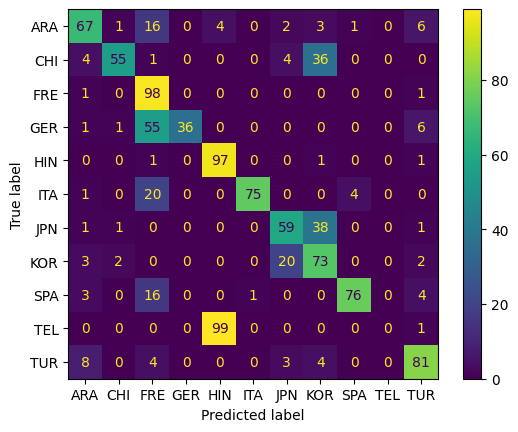

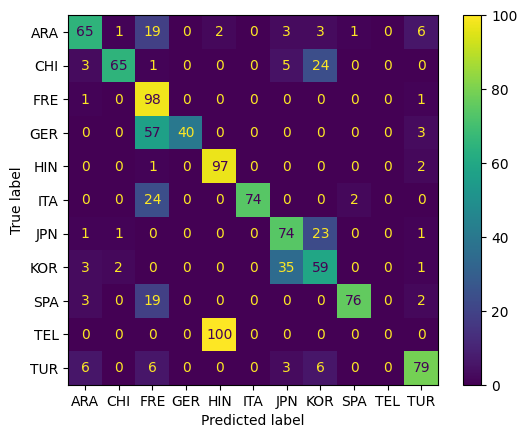

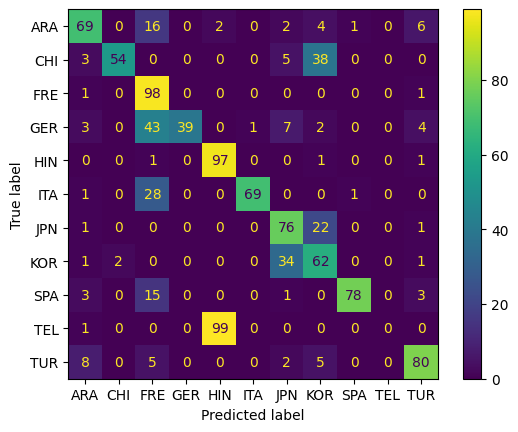

In [12]:
from unsloth import FastLanguageModel

accuracies = []
%cd /content/drive/MyDrive/thesis_NLI/TOEFL11
for count in range(3):
  model, tokenizer = FastLanguageModel.from_pretrained(
      model_name = f"finetuned_phi3_{count}", # YOUR MODEL YOU USED FOR TRAINING
      max_seq_length = max_seq_length,
      dtype = dtype,
      load_in_4bit = load_in_4bit,
    )
  FastLanguageModel.for_inference(model) # Enable native 2x faster inference

  eos_token = 'Response:'
  results_TOEFL = "/content/drive/MyDrive/thesis_NLI/TOEFL11/toefl_results.csv"
  predictions = classify(test_texts, test_labels, "TOEFL", eos_token, results_TOEFL, closedopen_setting='closed')
  accuracy = accuracy_score(test_labels, predictions)
  accuracy2 = "{:.2f}".format(accuracy*100)

  print(f'-------------Run: {count}')
  print(f'-------------Accuracy: {accuracy2}')
  accuracy=float(accuracy*100)
  accuracies.append(accuracy)
  cm = confusion_matrix(test_labels, predictions, labels=all_labels_TOEFL)
  cm_display = ConfusionMatrixDisplay(cm, display_labels=all_labels_TOEFL).plot()
  cm_display.figure_.savefig(f'/content/drive/MyDrive/thesis_NLI/TOEFL_results/finetuned_phi3_{count}.png')
  df = pd.read_csv(results_TOEFL)
  column_name = f'preds_finetuned_phi3_{count}'
  num_columns = len(df.columns)
  df.insert(num_columns, column_name, predictions)
    # df.head()
  df.to_csv(results_TOEFL, index=False)

runs=3
# accuracies.append(65.18)
avg_acc=sum(accuracies)/runs
print(accuracies)
print(f"Average acc: {avg_acc}")
print(f"Standard deviation: {np.std(accuracies)}")

You can also use Hugging Face's `AutoModelForPeftCausalLM`. Only use this if you do not have `unsloth` installed. It can be hopelessly slow, since `4bit` model downloading is not supported, and Unsloth's **inference is 2x faster**.

In [ ]:
if False:
    # I highly do NOT suggest - use Unsloth if possible
    from peft import AutoPeftModelForCausalLM
    from transformers import AutoTokenizer
    model = AutoPeftModelForCausalLM.from_pretrained(
        "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = load_in_4bit,
    )
    tokenizer = AutoTokenizer.from_pretrained("lora_model")

### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16 or `merged_4bit` for int4. We also allow `lora` adapters as a fallback. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Merge to 16bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False: model.save_pretrained_merged("model", tokenizer, save_method = "lora",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "lora", token = "")

### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

Some supported quant methods (full list on our [Wiki page](https://github.com/unslothai/unsloth/wiki#gguf-quantization-options)):
* `q8_0` - Fast conversion. High resource use, but generally acceptable.
* `q4_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K.
* `q5_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K.

In [ ]:
# Save to 8bit Q8_0
if False: model.save_pretrained_gguf("model", tokenizer,)
if False: model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# Save to 16bit GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

Now, use the `model-unsloth.gguf` file or `model-unsloth-Q4_K_M.gguf` file in `llama.cpp` or a UI based system like `GPT4All`. You can install GPT4All by going [here](https://gpt4all.io/index.html).

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/u54VK8m8tk) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Zephyr DPO 2x faster [free Colab](https://colab.research.google.com/drive/15vttTpzzVXv_tJwEk-hIcQ0S9FcEWvwP?usp=sharing)
2. Llama 7b 2x faster [free Colab](https://colab.research.google.com/drive/1lBzz5KeZJKXjvivbYvmGarix9Ao6Wxe5?usp=sharing)
3. TinyLlama 4x faster full Alpaca 52K in 1 hour [free Colab](https://colab.research.google.com/drive/1AZghoNBQaMDgWJpi4RbffGM1h6raLUj9?usp=sharing)
4. CodeLlama 34b 2x faster [A100 on Colab](https://colab.research.google.com/drive/1y7A0AxE3y8gdj4AVkl2aZX47Xu3P1wJT?usp=sharing)
5. Mistral 7b [free Kaggle version](https://www.kaggle.com/code/danielhanchen/kaggle-mistral-7b-unsloth-notebook)
6. We also did a [blog](https://huggingface.co/blog/unsloth-trl) with 🤗 HuggingFace, and we're in the TRL [docs](https://huggingface.co/docs/trl/main/en/sft_trainer#accelerate-fine-tuning-2x-using-unsloth)!
7. `ChatML` for ShareGPT datasets, [conversational notebook](https://colab.research.google.com/drive/1Aau3lgPzeZKQ-98h69CCu1UJcvIBLmy2?usp=sharing)
8. Text completions like novel writing [notebook](https://colab.research.google.com/drive/1ef-tab5bhkvWmBOObepl1WgJvfvSzn5Q?usp=sharing)

<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/u54VK8m8tk"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://ko-fi.com/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Kofi button.png" width="145"></a></a> Support our work if you can! Thanks!
</div>